# Parameter Identifiability

If you wish to infer the parameters of a model from data, it would be useful to ensure the parameters can be reliably inferred. If not then the results and any further analysis could be significantly affected and not reproducible. In this notebook, I will teach you how to determine parameter identifiability by going through some examples.

In [2]:
import pandas as pd
import numpy as np
import pints
import plotly.express.colors as pxclrs
import plotly.colors as pclrs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import figure_factory as ff
from scipy import integrate, optimize

image_file = "../Images/parameter_identifiability/"

base_colour = "rebeccapurple"
heat_col_scale = "dense"
cont_col_scale = "viridis"
disc_col_scale = pxclrs.qualitative.Safe

# To provide consistent results when rerunning the notebook
seed = 321
rng = np.random.default_rng(seed=seed)

## The logistic growth models

The first example I will use, will be comparing three different logistic growth models. The parameter identifiability of these models have already been analysed [1] and thus we can assess the accuracy of our methods in trying to reproduce the results. 

They all are defined in the form
$$        \dot{C} = rCf(C), $$
where $C(t)$ is the population density at time, $t$, $r>0$ is the growth rate and $f(C)$ is a capacity limiting function.

The three different models have different forms for $f(C)$:
- The standard logistic growth model:  $f(C)=(1-C/K)$, for a carrying capacity $K>0$.
- The gompertz growth model: $f(C)=\log(C/K)$
- The Richards growth model: $f(C)=(1-C/K)^{\beta}$ for some $\beta>0$

[1] M.J. Simpson, A.P. Browning et. al. Parameter identifiability and model selection for sigmoid population growth models, Journal of Theoretical Biology, Volume 535, 2022,
https://doi.org/10.1016/j.jtbi.2021.110998.

In [2]:
# Create a class to simulate the growth models
class LogisticGrowth():
    def __init__(self, model="Standard", IC=1) -> None:
        self.model = model
        if self.model == "Richards":
            self.n_parameters = 3  # r, K and beta
        else:
            self.n_parameters = 2  # r and K
        self.params = None
        self.IC = IC

    def set_params(self, parameter):
        if len(parameter) != self.n_parameters:
            raise TypeError(
                "Length of parameter does not match the number of " +
                "parameters, " + str(self.n_parameters) + ", required by" + 
                self.model + " growth model."
            )
        self.params = {
            "r": parameter[0],
            "K": parameter[1],
        }
        if self.model == "Richards":
            self.params["beta"] = parameter[2]
    
    def set_initial_condition(self, IC):
        self.IC = IC

    def ODE(self, C, t):
        """
            Takes the current population density, $C$, and time, $t$, and returns $\dot{C}$
        """
        if self.model == "Standard":
            fC = 1-C/self.params['K']
        elif self.model == "Gompertz":
            fC = np.log(C/self.params['K'])
        elif self.model == "Richards":
            fC = np.power(1-C/self.params['K'], self.params['beta'])

        dC_dt = self.params['r']*C*fC
        return dC_dt
    
    def analytic_solution(self, times):
        """
            Solves the Logistic Growth equation
        """
        C_0 = self.IC
        K = self.params['K']
        beta = 1
        if self.model == "Richards":
            beta = self.params['beta']
        exp_growth = np.exp(-self.params['r']*beta*times)
        if self.model == "Gompertz":
            C_t = K * np.exp(np.log(C_0/K) * exp_growth)
        else:
            Q =  np.power(K, beta)-np.power(C_0, beta)
            C_t = (K*C_0) /np.power((C_0**beta + Q*exp_growth), 1/beta)
        return C_t


    def numerical_solution(self, times):
        """
            Solves the Logistic Growth equation
        """

        # Get the solution to the ODEs
        results = integrate.odeint(
            self.ODE,
            self.IC,
            times
            )
        return results

    def simulate(self, parameter, times):
        """
            Return the population density simulated by the Logistic Growth
            equation for a specific parameter vector
        """
        
        self.set_params(parameter)
        if times[0] == 0:
            return self.analytic_solution(times)
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However the IC is for time t=0 and so we have to solve from that point
            times = np.concatenate((np.array([0]), times))
            return self.analytic_solution(times)[1:]
        else:
            raise ValueError(
                "Times must be greater than or equal to zero"
            )

Now that the model has been built, we can determine the resulting population-time profiles of this model.

In [3]:
r3 = 20
K = 10
betas = [0.1, 0.3, 0.5, 1]
models = ["Standard", "Gompertz", "Richards"]

fig = make_subplots(
    rows=1, cols=len(betas), subplot_titles=np.char.add("beta = ", np.array(betas, dtype=str))
)

for i_m, m in enumerate(models):
    model = LogisticGrowth(m, IC=0.1)
    for col, b in enumerate(betas):
        r_times = np.linspace(0, 10, 100)
        if m == "Standard":
            param = [r3, K]
            times = r_times/param[0]
        elif m == "Gompertz":
            param = [r3*b, K]
            times = r_times/param[0]
        elif m == "Richards":
            param = [r3, K, b]
            times = r_times/(r3*b)
        solution = model.simulate(param, times)
    
        fig.add_trace(
            go.Scatter(
                name=m+" growth model",
                x=r_times,
                y=solution/K,
                mode='lines',
                line=dict(color=disc_col_scale[i_m]),
                showlegend=col==0,
                legendgroup=m
            ),
            row=1,
            col=col+1
        )

fig.update_layout(
    template='plotly_white',
    width=1000,
    height=400,
)
fig.show()

### Simulated data

To determine the correct model and parameters to use for a particular situation, the model needs to be compared to some data. For this we will use datasets simulated from each of the models, using the maximum likelihood estimates accquired from the paper. We will also add constant gaussian noise with standard deviation, $\sigma$, to the solution.


In [4]:
def create_data(m, parameters):
    mech_params = parameters[:-2]
    C_0 = parameters[-2]
    sigma = parameters[-1]
    sim_times = np.linspace(0, 4000, 11)
    model = LogisticGrowth(m, IC=C_0)
    solution = model.simulate(mech_params, sim_times)
    noise = rng.normal(loc=0, scale = sigma, size=len(sim_times))
    noisy_data = solution+noise

    # Any negative data points should be positive
    noisy_data = np.abs(noisy_data)
    data = {
        "model": m,
        "t": sim_times,
        "C": noisy_data,
        "Parameters": parameters,
    }
    return data

In [5]:
# Standard Logistic growth model parameters:
r = 2.5e-3
K = 80
C_0 = 0.7
sigma = 2.3

standard_data = create_data("Standard", [r, K, C_0, sigma])

# Gompertz logistic growth model parameters:
r = 1.6e-3
K = 83
C_0 = 1.1e-4
sigma = 2.7

gompertz_data = create_data("Gompertz", [r, K, C_0, sigma])

# Richards' logistic growth model parameters:
r = 5.5e-3
K = 82
C_0 = 9.4e-2
beta = 0.3
sigma = 2.1

richards_data = create_data("Richards", [r, K, beta, C_0, sigma])


In [6]:
fig = go.Figure()
datas = [standard_data, gompertz_data, richards_data]
for i_m, data in enumerate(datas):
    fig.add_trace(
        go.Scatter(
            name= "data",
            x=data["t"],
            y=data["C"],
            mode='markers',
            line=dict(color=disc_col_scale[i_m]),
            showlegend=True,
            legendgroup=data["model"],
            legendgrouptitle=dict(
                text=data["model"]+" growth model"
            )
        )
    )
    parameters = data["Parameters"]
    model = LogisticGrowth(data["model"], IC=parameters[-2])
    more_times = np.linspace(0, 4000, 1000)
    solution = model.simulate(parameters[:-2], more_times)
    fig.add_trace(
        go.Scatter(
            name= "Simulated curve",
            x=more_times,
            y=solution,
            mode='lines',
            line=dict(color=disc_col_scale[i_m]),
            showlegend=True,
            legendgroup=data["model"],
            legendgrouptitle=dict(
                text=data["model"]+" growth model"
            )
        )
    )
fig.update_layout(
    template='plotly_white',
    width=600,
    height=400,
)
fig.write_image(image_file+"/Log_Growth_Data.svg")
fig.show()

## Maximum likelihood

A common approach to parameter inference is to maximise the probability the data, $X^{obs}$, was generated by the model with parameters, $\theta \in \Theta$, over the parameter space $\Theta$. This probability, $P\left(X^{obs}|\theta\right)$, is called the likelihood. We can test whether the parameters of our models, $\theta = (r, K, \beta, C_0, \sigma)$, can be reliably recovered from the data. 

First we need to define the likelihood. For this example, I will use a constant gaussian likelihood as additive noise was used to generate the data. In most caes we will not know the exact type of noise present in a data set and so some assumptions will need to be made. The Likelihood can be calculated as the product of point-wise likelihoods,
\begin{equation*}
    P\left(X^\textrm{obs}|\theta\right) = \prod_{x^{obs}_i \in X^\textrm{obs}} P\left(x^{obs}_i|\theta\right).
\end{equation*}
Alternatively, a computationally easier but equivalent optimisation is the log-likelihood,
\begin{equation*}
    \log\left(P\left(X^\textrm{obs}|\theta\right)\right) = \sum_{x^{obs}_i \in X^\textrm{obs}} \log\left(P\left(x^{obs}_i|\theta\right)\right),
\end{equation*}
As we are using a Gaussian noise, each of these pointwise observations are expected to be normally distributed around the true value, $\mu_i$, i.e.  $x^{obs}_i \sim N\left(\mu_i, \sigma^2\right)$ where $\sigma$ is the standard deviation of the observations. Thus the pointwise likelihood can be formulated as a Gaussian distribution,
\begin{align*}
    P\left(x^{obs}_i|\theta\right) &= P\left(x^{obs}_i|\mu_i = x^{\theta}\left(t_i\right), \sigma\right) \\
    &= \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\left(x^{obs}_i - x^\theta\left(t_i\right)\right)^2\left(\sigma \right)^{-2} },
\end{align*}
where $x^{\theta}$ is the simulated dynamical model under parameters $\theta$. Thus the log-likelihood is 
\begin{align*}
    \log \left(P\left(X^{obs}|\theta\right)\right) &= \sum_{x^{obs}_i \in X^\textrm{obs}} \left(-\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma \right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma }\right)^2\right).
\end{align*}

So now let's build a function that returns this likelihood.

In [7]:
class GrowthLogLikelihood():
    def __init__(self, times, observations, model) -> None:
        self.model = LogisticGrowth(model=model)
        self.times=times
        self.obs=observations
    
    def log_likelihood(self, parameters):
        # Parameters must be positive
        parameters = np.array(parameters)
        if any(parameters<0):
            return -np.inf
        sigma = parameters[-1]
        C_0 = parameters[-2]
        n_obs = len(self.times)

        self.model.set_initial_condition(C_0)
        x_theta = self.model.simulate(parameters[:-2], self.times)
        # Numerical errors can turn up negative results which affects likelihood calculation
        if any(x_theta<=0):
            x_theta[x_theta<=0] = 1e-20 
        
        term_1 = -0.5*n_obs*np.log(2*np.pi)
        term_2 = -n_obs*np.log(sigma)
        term_3 = -(0.5/sigma**2) * np.sum((self.obs - x_theta)**2)

        log_likelihood = term_1 + term_2 + term_3
        return log_likelihood


And maximise this function for each of the models, to find the MLE. I will use the ProfileLikelihood class to do this, which is found in the code section if you wish to investigate further.

In [8]:
from Code.Profile_loglikelihood import ProfileLogLikelihood

approx_params = np.array([3e-3, 100, 0.5, 0.001, 1])
n_runs = 10
# acqire 4 random start points for optimisation
start_params = np.abs(1+rng.normal(size=(n_runs, 5)))*approx_params
param_names = ["r", "K", "beta", "C_0", "sigma"]

for data in datas:
    data["log_like"] = GrowthLogLikelihood(data['t'], data['C'], data['model'])
    if data['model'] != 'Richards':
        approx_m = np.delete(approx_params, 2)
        start_m = np.delete(start_params, 2, axis = 1)
        names_m = np.delete(param_names, 2)
    else:
        approx_m = approx_params
        start_m = start_params
        names_m = param_names

    data["PLL"] = ProfileLogLikelihood(data["log_like"].log_likelihood, approx_m)
    MLEs, LL_scores = data["PLL"].max_likelihood_estimate(
        n_runs=n_runs, param_start = start_m,
        opts={
            'optimiser': 'CMAES', 'opt_package': 'pints',
            'random_seed': seed, 'lower_bounds': 0, 'maxiter': 1e5
        }
    )

    print(data['model'] + " Growth Model")
    table_df = pd.DataFrame(
        MLEs,
        columns=names_m
    )
    table_df["Log-likelihood"] = LL_scores
    table_df = table_df.reindex(list(range(0, n_runs))+["True"])
    table_df.loc["True"] = data['Parameters'] + [
        data["log_like"].log_likelihood(data['Parameters'])
    ]
    table_df = table_df.round(4)
    fig = ff.create_table(table_df, index=True)
    fig.update_layout(
        width=600,
        height=300,
    )
    fig.show()


Standard Growth Model


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3655: RuntimeWarning:

invalid value encountered in scalar subtract



Gompertz Growth Model


Richards Growth Model


From the above results, There may be some identifiability problems with the Standard and Richards' growth model. However, as it is a random process, there is always a chance that the optimiser does not find the global maximum. Five runs of the maximum likelihood estimation is not enough to quantify the identifiability. To achieve this, we need to view the Profile likelihood.

### Profile Likelihood

To determine Parameter Identifiability we can examine the profile likelihoods of the parameters. To do this, each parameter is varied around the optimised value, and the log-likelihood for the other parameters re-optimised, i.e.:
\begin{equation}
    PL\left(\theta_i\right) = \max_{\theta_{-i}}\left(\log\left(P\left(X^\textrm{obs} | \theta_i, \theta_{-i}\right)\right)\right)
\end{equation}
for each parameter $\theta_i$, where $\theta_{-i}$ are all parameters excluding $\theta_i$. This is then compared with a vertical confidence line where the intersection of this line to the profile likelihood curve indicates the confidence interval. For a confidence interval of 95\% a confidence line at 1.92 below the maximum is used. If the curve acquired from $PL\left(\theta_i\right)$ does not cross the confidence line on one or both sides of the maximum then the parameters are unidentifiable. We have already performed a global optimisation, we can use this as the starting point for subsequent optimisations.

In [9]:
# As we have run the MLE function, this has been set for the start of profile likelihood
opts = {
    # 'optimiser': 'CMAES',
    # 'opt_package': 'pints',
    'method': 'sequential calc.',
    'max_N_opts': 50,
    'interp':0,
    'lower_bounds': 0,
    'random_seed': seed
}
timer = pints.Timer()
slow_times = {}
row_names = list(np.array(param_names)[[0, 1, 3, 2]])
col_names = ["Standard", "Gompertz", "Richards'"]
fig1 = make_subplots(rows=4, cols=3, column_titles=col_names , row_titles=row_names)
for i_m, data in enumerate(datas):
    print(data['model'] )
    data["PLL"].set_options(opts, reset=True)

    bounds = [[0, 0.01], [60, 100]]
    if data['model'] == 'Standard':
        data['bounds'] = bounds + [[0.01, 2]]
        names_m = zip(range(0, 3), row_names[:-1])
    elif data['model'] == 'Gompertz':
        data['bounds'] = bounds + [[0, 0.015]]
        names_m = zip(range(0, 3), row_names[:-1])
    else:
        data['bounds'] = bounds + [[0, 1], [0, 1]]
        # data['bounds'][0] = []
        names_m = zip([0, 1, 3, 2], row_names)
    data["PLL"].set_param_range(range(0, len(data['bounds'])), bounds=data['bounds'], adapt=False)
    row = 0
    for i_param, param in names_m:
        print("\t", param)
        row += 1
        timer.reset()
        result = data["PLL"].run(i_param, n_points = 200)
        slow_times[(data['model'], param)] = timer.time()
        fig1.add_trace(
            go.Scatter(
                name= "Profile Likelihood",
                x=result[0],
                y=result[1],
                mode='lines',
                line=dict(color=disc_col_scale[i_m], dash='dash'),
                showlegend=i_param==0,
                legendgroup=data["model"],
                legendgrouptitle=dict(
                    text=data["model"]+" growth model"
                )
            ), row=row, col=i_m+1
        )
        # fig.add_trace(
        #     go.Scatter(
        #         name= "Simulated curve",
        #         x=more_times,
        #         y=solution,
        #         mode='lines',
        #         line=dict(color=disc_col_scale[i_m]),
        #         showlegend=True,
        #         legendgroup=data["model"],
        #         legendgrouptitle=dict(
        #             text=data["model"]+" growth model"
        #         )
        #     )
        # )

fig1.update_layout(
    template='plotly_white',
    width=900,
    height=800,
)
fig1.show()

Standard
	 r


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



Used global optimisation on shape points [0.00040816326530612246]
	 K
	 C_0
Gompertz
	 r
Used global optimisation on shape points [0.0012244897959183673]
	 K
	 C_0


/tmp/ipykernel_115568/2079233855.py:54: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_115568/2079233855.py:54: RuntimeWarning:

invalid value encountered in multiply



Used global optimisation on shape points [0.0]
Richards
	 r
Used global optimisation on shape points [0.0006122448979591836]
	 K
	 C_0


/tmp/ipykernel_115568/2079233855.py:57: RuntimeWarning:

invalid value encountered in divide



Used global optimisation on shape points [0.0]
	 beta


/tmp/ipykernel_115568/2079233855.py:57: RuntimeWarning:

divide by zero encountered in scalar divide



Used global optimisation on shape points [0.0]


In [10]:
# As we have run the MLE function, this has been set for the start of profile likelihood
opts = {
    # 'optimiser': 'CMAES',
    # 'opt_package': 'pints',
    'method': 'quadratic approx.',
    'max_N_opts': 40,
    'approx shape N': 10,
    'interp': 0,
    'lower_bounds': 0,
    'seed': seed
}
first_l = True
first_MLE = True
first_U = True
fig2 = make_subplots(rows=4, cols=3)
df_ident = pd.DataFrame(columns=["Model", "Parameter", "Lower", "Upper", "Time Change"])
data["PLL"].result = {}
for i_m, data in enumerate(datas):
    print(data['model'])
    data["PLL"].set_options(opts, reset=True)

    if data['model'] == 'Standard':
        names_m = zip(range(0, 3), row_names[:-1])
    elif data['model'] == 'Gompertz':
        names_m = zip(range(0, 3), row_names[:-1])
    else:
        names_m = zip([0, 1, 3, 2], row_names[:])
    data["PLL"].set_param_range(range(0, len(data['bounds'])), bounds=data['bounds'], adapt=False)
    row = 0
    for i_param, param in names_m:
        print("\t", i_param, param)
        row += 1
        timer.reset()
        result = data["PLL"].run(i_param, n_points = 200)
        quick_time = timer.time()
        time_change = (
            quick_time - slow_times[(data['model'], param)]
        )/slow_times[(data['model'], param)]
        time_change = str(round(time_change*100, 2)) + "%"
        identifiability = data["PLL"].result[i_param]['identifiabilty']
        df_ident.loc[len(df_ident.index)] = [
            data['model'], param, identifiability[0], identifiability[1],
            time_change
        ]
        fig2.add_trace(
            go.Scatter(
                name= "Quick Profile Likelihood",
                x=result[0],
                y=result[1],
                mode='lines',
                line=dict(color=disc_col_scale[i_m]),
                showlegend=i_param==0,
                legendgroup=data["model"],
                legendgrouptitle=dict(
                    text=data["model"]+" growth model"
                )
            ), row=row, col=i_m+1
        )
        x_CI, LL_CI, _ = data["PLL"].result[i_param]['CI']
        if identifiability[0]=='Ident':
            fig2.add_trace(
                go.Scatter(
                    name= "Lower confidence interval",
                    x=[x_CI[0], x_CI[0]],
                    y=[LL_CI[0], -5],  # min(result[1, np.isfinite(result[1])])],
                    mode='lines',
                    line=dict(color='darkgrey', dash='dash'),
                    showlegend=first_l,
                    legendgroup="CI",
                    legendgrouptitle=dict(
                        text="Confidence Interval"
                    )
                ), row=row, col=i_m+1
            )
            first_l = False
        fig2.add_trace(
            go.Scatter(
                name= "MLE",
                x=[x_CI[1], x_CI[1]],
                y=[LL_CI[1], -5],   # min(result[1, np.isfinite(result[1])])],
                mode='lines',
                line=dict(color='darkgrey'),
                showlegend=first_MLE,
                legendgroup="CI",
                legendgrouptitle=dict(
                    text="Confidence Interval"
                )
            ), row=row, col=i_m+1
        )
        first_MLE = False
        if identifiability[1]=='Ident':
            fig2.add_trace(
                go.Scatter(
                    name= "Upper confidence interval",
                    x=[x_CI[2], x_CI[2]],
                    y=[LL_CI[2], -5],   # min(result[1, np.isfinite(result[1])])],
                    mode='lines',
                    line=dict(color='darkgrey', dash='dash'),
                    showlegend=first_U,
                    legendgroup="CI",
                    legendgrouptitle=dict(
                    # k=2, w=weights, s=5e-2*len(weights)
                        text="Confidence Interval"
                    )
                ), row=row, col=i_m+1
            )
            first_U = False
        optimiser_points = data["PLL"].result[i_param]['opt points']
        fig2.add_trace(
            go.Scatter(
                name='Optimiser Evaluations',
                x=optimiser_points[0],
                y=optimiser_points[1],
                mode='markers',
                marker=dict(
                    color=disc_col_scale[i_m],
                    symbol="star-diamond",
                    opacity=0.5
                ),
                showlegend=i_param==0,
                legendgroup=data["model"],
            ), row=row, col=i_m+1
        )
fig = go.Figure(data = fig1.data + fig2.data).set_subplots(
    4, 3, column_titles=col_names , row_titles=row_names
)
fig.update_yaxes(range=[-5, 2.1], title = "Log-likelihood - L^*")
fig.update_layout(
    template='plotly_white',
    width=900,
    height=800,
)
fig.write_image(image_file+"/Log_Growth_PLL_QPLL.svg")
fig.show()

df_ident.replace(['Ident', 'Unident', None], ['Identifiable', 'Unidentible', 'Unknown'])
fig3 = ff.create_table(df_ident)
fig3.update_layout(
    width=600,
    height=300,
)
fig3.write_image(image_file+"/Log_Growth_QPLL_Table.svg")
fig3.show()

Standard
	 0 r


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2418: RuntimeWarning:

invalid value encountered in scalar subtract

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2419: RuntimeWarning:

invalid value encountered in scalar subtract



	 1 K
	 2 C_0


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



Used global optimisation on shape points [0.8944444444444445]
Gompertz
	 0 r


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



	 1 K


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



	 2 C_0


/tmp/ipykernel_115568/2079233855.py:54: RuntimeWarning:

divide by zero encountered in log

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Profile_loglikelihood.py:699: UserWarning:

Convergence is slow, quadratic approximation may not be appropriate

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Profile_loglikelihood.py:761: UserWarning:

Convergence is slow, quadratic approximation may not be appropriate

/tmp/ipykernel_115568/2079233855.py:54: RuntimeWarning:

invalid value encountered in multiply

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



Richards
	 0 r


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Profile_loglikelihood.py:761: UserWarning:

Convergence is slow, quadratic approximation may not be appropriate

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2418: RuntimeWarning:

invalid value encountered in scalar subtract

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2419: RuntimeWarning:

invalid value encountered in scalar subtract



Used global optimisation for CI finding on points [0.0008082  0.00085334 0.00121001]
Used global optimisation on shape points [0.0011111111111111111]
	 1 K


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply



	 3 C_0


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Profile_loglikelihood.py:761: UserWarning:

Convergence is slow, quadratic approximation may not be appropriate

/tmp/ipykernel_115568/2079233855.py:57: RuntimeWarning:

invalid value encountered in divide



	 2 beta


/tmp/ipykernel_115568/2079233855.py:57: RuntimeWarning:

divide by zero encountered in scalar divide

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning:

invalid value encountered in scalar multiply

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Profile_loglikelihood.py:699: UserWarning:

Convergence is slow, quadratic approximation may not be appropriate



Used global optimisation on shape points [0.0, 0.1111111111111111, 0.2222222222222222]


## The PK model

The second example I will go through in this notebook is a one-compartment Pharmacokinetic (PK) model. PK models are mathematical models of the concentration of the drug throughout the body over time and the one-compartment model with linear rates is the simplest of these. In the one-compartment model the body is abstracted into a central compartment. At time $t=0$, the drug is injected straight into the central compartment. Over time, the drug is then cleared from the compartment. This model is given by the following ordinary differential equation (ODE),
$$
        \dot{A_c} = - K_\textrm{cl}\frac{A_c}{V_c},
$$
where $A_c$ is the mass of drug in the central compartment, $V_c$ is the volume of the central compartment, and $K_\textrm{cl} >0$ is the rate of clearance from the central compartment. The initial condition of this model is $A_c(0) = d$, the drug dose amount. We will utilise the CHI package to build this model.

In [3]:
import chi.library
import chi

# Define 1-compartment pharmacokinetic model
mechanistic_model = chi.library.ModelLibrary().one_compartment_pk_model()

INFO:root:running build_ext
INFO:root:building 'myokit_sim_1_8175634198533258443' extension
INFO:root:creating build
INFO:root:creating build/temp.linux-x86_64-cpython-310
INFO:root:creating build/temp.linux-x86_64-cpython-310/tmp
INFO:root:creating build/temp.linux-x86_64-cpython-310/tmp/tmp5owv3c37myokit
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/include -I/opt/local/include -I/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/myokit/_sim -I/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/myokit/_sim -I/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/include -I/usr/include/python3.10 -c /tmp/tmp5owv3c37myokit/source.c -o build/temp.linux-x86_64-cpython-310/tmp/tmp5owv3c37myokit/source.o
INFO:root:creating build/lib.linux-x86_64-cpython-310
INFO:root

In [8]:
V_c = 5.58
K_cl = 2.8
dose_amts = [1, 2, 3]
times = np.linspace(0, 5, 100)

fig = go.Figure()

for i_dose, d in enumerate(dose_amts):
        param = [d, V_c, K_cl]
        solution = mechanistic_model.simulate(param, times)
    
        fig.add_trace(
            go.Scatter(
                name="Dose amount: "+str(d)+" mg",
                x=times,
                y=solution[0],
                mode='lines',
                line=dict(color=disc_col_scale[i_dose]),
                showlegend=True
            ),
        )

fig.update_layout(
    template='plotly_white',
    width=500,
    height=400,
)
fig.show()

In [11]:
class PKLin2Comp():
    def __init__(self, dose):
        self.n_parameters = 4
        self.dose = dose
        self.params = None
        
    def set_params(self, parameter):
        self.params = {
            "V_c": parameter[0],
            "K_cl": parameter[1],
            "V_p": parameter[2],
            "K_p": parameter[3]
        }
        
    
    def ODE(self, A, t):
        """
            Takes the current amount of drug, A, in the compartments and time, t, and returns dA_dt
        """
        dA_c_dt = (
            self.params["K_p"]*(A[1]/self.params["V_p"]) -
            (self.params["K_p"]+self.params["K_cl"])*(A[0]/self.params["V_c"])
        )
        dA_p_dt = (
            self.params["K_p"]*((A[0]/self.params["V_c"]) - (A[1]/self.params["V_p"]))
        )

        dA_dt = np.asarray([dA_c_dt, dA_p_dt])

        return dA_dt
    
    
    def solve(self, times):
        """
            Solves the PK system of ODEs
        """
        
        # Set the initial condition.
        A_0 = [self.dose, 0]

        # Get the solution to the ODEs
        results_amt = integrate.odeint(
            self.ODE,
            A_0,
            times,
#             rtol=1.49012e-12,
#             atol=1.49012e-12
#             hmax = 1e-4
            )

        # Convert amount of drug to concentration of drug
        results_conc = results_amt/np.asarray([self.params["V_c"], self.params["V_p"]])
        return results_conc
    
    def simulate(self, parameter, times):
        """
            Returns the concentration of drug over time, given a set of parameters. Assumes that dosing happens at time t=0
        """
        
        self.set_params(parameter)
        
        if times[0] == 0:
            return self.solve(times)[:]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            return self.solve(times)[1:]
        elif times[0] < 0:  
            # If the times start before t=0 then we will need to return 0 for all the negative time points and
            # then start the simulation after those.
            times_after_zero = times[times >= 0]
            zeros = np.zeros((len(times) - len(times_after_zero), 2))
            times_after_zero = np.concatenate((np.array([0]), times_after_zero))
            
            return np.concatenate((zeros, self.solve(times_after_zero)[1:]))

Now that the model has been built, we can see what the resulting concentration-time profiles of this model are.

In [12]:
doses = [1.0, 2.0, 4.0] # mg
PK_param_names = ["V_c", "K_cl", "V_P", "K_p"]
PK_param_value = [1,     2.8,    4.8,   2.3]

fig, ax = plt.subplots(2, 1)
times = np.linspace(-0.01, 5, 1000)

for dose in doses:
    PK_model = PKLin2Comp(dose)
    solution = PK_model.simulate(PK_param_value, times)
    
    ax[0].plot(
        times,
        solution[:, 0],
        label='Dose: '+str(dose)
        )
    ax[1].plot(
        times,
        solution[:,1],
        )

ax[0].set_yscale("log")
ax[1].set_yscale("log") # It is easier to view the graph on a log scale
fig.legend()
fig.show()

NameError: name 'plt' is not defined

## The data

If you are performing parameter inference, this requires data to infer the parameters from. This data is also used in parameter identifiability. For this example, I will generate some data from the model to use in place of experimental data. In experiments the observation is usually of the concentration of drug in the blood stream and so we are only concerned with the central compartment.

In [4]:
dose_amount = 2.0

PK_model = PKLin2Comp(dose_amount)
data_times = np.linspace(0.1, 5, 5) # In vivo PK data tends to be very sparse
values_no_noise = PK_model.simulate(PK_param_value, data_times)[:,0]

# We will use multiplicative gaussian noise to generate to data as that is commonly seen in experimental PK data
sigma = 0.1
noise = rng.normal(0, sigma, len(data_times))
values_noisey = values_no_noise*(1+noise)

df = pd.DataFrame()
df["TIME"] = data_times
df["OBS"] = values_noisey
df

,TIME,OBS
0,0.100,0.922239
1,1.325,0.070370
2,2.550,0.043447
3,3.775,0.035829
4,5.000,0.028234


We can also visualise the data on a graph:

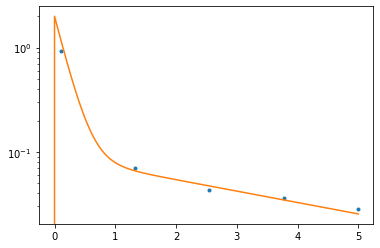

In [5]:
# dose_amount = 2.0
# PK_model = PKLin2Comp(dose_amount)

more_times = np.linspace(-0.01, max(data_times),1000)
more_values = PK_model.simulate(PK_param_value, more_times)[:,0]

plt.plot(df["TIME"], df["OBS"], '.')
plt.plot(more_times, more_values)
plt.yscale("log")

In [6]:
def minus_log_likelihood(parameters, times, observations):
    sigma = parameters[-1]
    n_obs = len(times)
    x_theta = PK_model.simulate(parameters[:-1], times)[:,0]
    if any(x_theta<=0):
        x_theta[x_theta<=0] = 1e-20 # Numerical errors can turn up negative results which affects likelihood calculation
    term_1 = 0.5*n_obs*np.log(2*np.pi)
#     print(term_1)
    term_2 = np.sum(np.log(sigma*x_theta))
#     print(sigma*x_theta)
    term_3 = (0.5/sigma**2) * np.sum((observations - x_theta)**2/x_theta**2)
#     print(term_3)
    log_likelihood = term_1 + term_2 + term_3
    return log_likelihood
print("Log-Likelihood of parameters theta =", PK_param_value+[sigma], "is", -minus_log_likelihood(PK_param_value+[sigma], df["TIME"], df["OBS"]))

Log-Likelihood of parameters theta = [1, 2.8, 4.8, 2.3, 0.1] is 15.514012073206807


Using the first two points in the data we can make an initial estimate in the value of $V_c$. We can then use this to help our optimiser narrow into the correct value quicker.

In [7]:
point_1 = (df['TIME'][0], df['OBS'][0])
point_2 = (df['TIME'][1], df['OBS'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
V_c_approx = dose_amount/y_0
print("Aproximate V_C:", V_c_approx)

Aproximate V_C: 2.0165783733813094


Now to optimise. We will use the global optimiser difeferential evolution.

In [8]:
#Set the boundaries of the search space
bounds = [
    (0.1*V_c_approx, 10*V_c_approx), # V_c
    (0.01, 100),  # K_cl
    (0.01*V_c_approx, 100*V_c_approx),  # V_p
    (0.01, 100),  # K_p
    (0.0001, 1)  # sigma
]

# Now lets optimize 5 times and see what the outcome of each optimisation is. This can take a little bit of time.
results = []
for col in range(0,5):
    optimum = optimize.dual_annealing(minus_log_likelihood, bounds, args = (df["TIME"], df["OBS"]))
    results.append(np.concatenate((optimum.x, [-optimum.fun])))
    print("Run", col, "optimum:", optimum.x, ", log likelihood:", -optimum.fun)

Run 0 optimum: [1.6013948  2.64132883 6.66092655 2.25678574 0.00960539] , log likelihood: 28.899531202996705
Run 1 optimum: [1.60139424 2.64132886 6.66092379 2.25678583 0.00960564] , log likelihood: 28.89953120468422
Run 2 optimum: [1.60139467 2.6413296  6.66091981 2.25678612 0.00960554] , log likelihood: 28.89953120573028
Run 3 optimum: [1.60139497 2.64132976 6.66092181 2.25678672 0.00960555] , log likelihood: 28.899531205453073
Run 4 optimum: [0.61257155 3.27569622 7.77118696 4.71559308 0.0625769 ] , log likelihood: 19.519360565475065


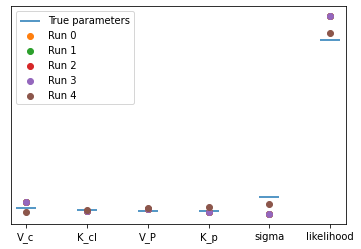

In [9]:
ll_true = -minus_log_likelihood(PK_param_value+[sigma], df["TIME"], df["OBS"])
l_bound = np.concatenate((np.asarray(bounds)[:,0], [ll_true-100]))
u_bound = np.concatenate((np.asarray(bounds)[:,1], [ll_true+10]))

rel_position = (np.asarray(PK_param_value+[sigma]+[ll_true])-l_bound)/(u_bound-l_bound)
plt.scatter(
    PK_param_names+["sigma"]+["likelihood"], 
    rel_position, 
    label="True parameters", 
    marker="_", 
    s=20 ** 2
)

for col, optimum in enumerate(results):
    rel_position = (optimum-l_bound)/(u_bound-l_bound)
    plt.scatter(PK_param_names+["sigma"]+["likelihood"], rel_position, label = "Run "+str(col))
plt.legend()
plt.yticks([], [])
plt.show()

The above optimisations may differ from one another and can give an indication on whether this is identifiable or not. However, this is does not definitively inform us how identifiable any of the parameters are. As this optimisation algorithm has stochastic processes, by chance it may have all found the same local minima or different ones.

## Profile likelihood

To determine Parameter Identifiability we can examine the profile likelihoods of the parameters. To do this, each parameter is varied around the optimised value, and the log-likelihood for the other parameters re-optimised, i.e.:
\begin{equation}
    PL\left(\theta_i\right) = \max_{\theta_{-i}}\left(\log\left(P\left(X^\textrm{obs} | \theta_i, \theta_{-i}\right)\right)\right)
\end{equation}
for each parameter $\theta_i$, where $\theta_{-i}$ are all parameters excluding $\theta_i$. This is then compared with a vertical confidence line where the intersection of this line to the profile likelihood curve indicates the confidence interval. For a confidence interval of 95\% a confidence line at 1.92 below the maximum is used. If the curve acquired from $PL\left(\theta_i\right)$ does not cross the confidence line on one or both sides of the maximum then the parameters are unidentifiable. We have already performed a global optimisation, we can use this as the starting point for subsequent optimisations.

In [10]:
# Excluding run 4 as this was an outlier in my case, change for your runs.
exclude_outliers = np.asarray(results[0:4])
start_point = np.average(exclude_outliers[:,:-1], axis=0)

print('Initial point for profile likelihood')
for col in range(0,len(PK_param_names)):
    print(PK_param_names[col] + " = " + str(start_point[col]))

Initial point for profile likelihood
V_c = 1.601394668161519
K_cl = 2.641329262924137
V_P = 6.660922990213748
K_p = 2.2567861060085557


Now to define the algorithm that will perform the optimisation.

In [11]:
def single_profile_loglikelihood(param_index, param_range, point_start):
    likelihood = []
    point = point_start.copy()
    PL_bounds = bounds.copy()
    i=0
    
    for theta_i in param_range:
        PL_bounds[param_index] = (theta_i, theta_i) # ensure the parameter theta_i is fixed in the optimisation
        point[param_index] = theta_i

        opt = optimize.minimize(minus_log_likelihood, point, bounds=PL_bounds, args = (df["TIME"], df["OBS"]))
        
        print(
            "\r", 
            str(int(i/len(param_range)*100))
            + "% complete",
            sep=' ', 
            end='', 
            flush=True
        )
        i+=1
        
                
        point = opt.x
        loglike = -opt.fun
        likelihood.append([theta_i, loglike])
    return likelihood

likelihoods = {}
for param_index in range(0, 5):
    print("\n Profile likelihood for " + (PK_param_names+["sigma"])[param_index]+ " lower:")
    n=0
    param_range = np.linspace(1*start_point[param_index], 0.5*start_point[param_index], 100)
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, start_point)
    likelihood_lower.reverse()
    print("\n Profile likelihood for " + (PK_param_names+["sigma"])[param_index]+ " upper:")
    
    param_range = np.linspace(1*start_point[param_index], 1.5*start_point[param_index], 100)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, start_point)
    likelihoods[param_index] = np.asarray(likelihood_lower + likelihood_upper)
    
#     n+=1
#     param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
#     likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
#     likelihood_lower.reverse()
#     likelihood = np.array(likelihood_lower+likelihood_upper)


 Profile likelihood for V_c lower:
 6% complete

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


 99% complete14% complete35% complete75% complete
 Profile likelihood for V_c upper:
 99% complete12% complete35% complete89% complete
 Profile likelihood for K_cl lower:
 99% complete% complete17% complete40% complete
 Profile likelihood for K_cl upper:
 99% complete% complete46% complete87% complete
 Profile likelihood for V_P lower:
 99% complete51% complete65% complete
 Profile likelihood for V_P upper:
 99% complete% complete46% complete83% complete
 Profile likelihood for K_p lower:
 99% complete% complete32% complete53% complete81% complete
 Profile likelihood for K_p upper:
 99% complete60% complete
 Profile likelihood for sigma lower:
 99% complete
 Profile likelihood for sigma upper:
 99% complete% complete35% complete42% complete59% complete61% complete

<ipython-input-17-83d365ca449f>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


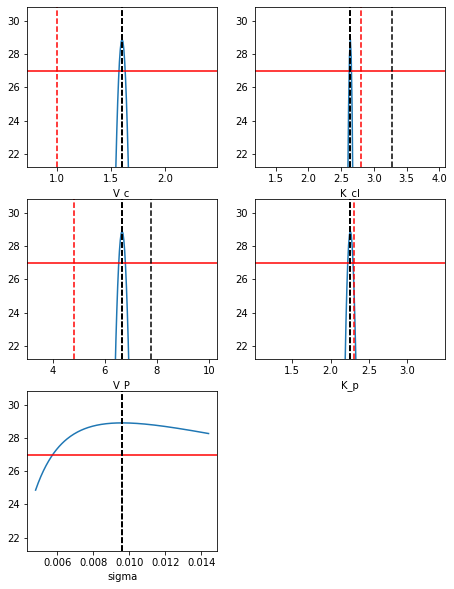

In [17]:
fig, ax = plt.subplots(3, 2)
param_values = PK_param_value + [sigma]
fig.set_size_inches(7.5, 10)

#Mechanistic Parameters
for col in range(0,5):
    likelihood = likelihoods[col]
    ax[int(col/2), col%2].plot(likelihood[:,0], likelihood[:,1])
    ax[int(col/2), col%2].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
    for run in results:
        if (run[col]<likelihood[-1,0] and run[col]>likelihood[0,0]):
            ax[int(col/2), col%2].axvline(x=run[col], linestyle='--', color='black')
    if (param_values[col]<likelihood[-1,0] and param_values[col]>likelihood[0,0]):
        ax[int(col/2), col%2].axvline(x=param_values[col], linestyle='--', color='red')
        
    ax[int(col/2), col%2].set_xlabel((PK_param_names+["sigma"])[col])
    ax[int(col/2), col%2].set_ylim([np.max(likelihood[:,1])-(3.84*2), np.max(likelihood[:,1])+1.92])


ax[2, 1].set_axis_off()
fig.show()

As we can see here $\sigma$ seems to be unidentifiable. If we observe it over the full width of boundaries. 


 Profile likelihood for sigma lower:
 9% complete

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


 99% complete45% complete81% complete
 Profile likelihood for sigma upper:
 99% complete% complete23% complete43% complete44% complete46% complete59% complete92% complete

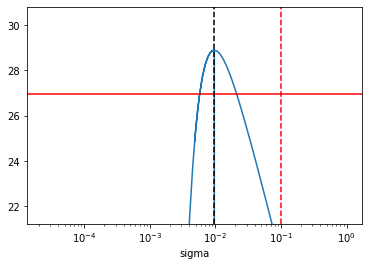

In [15]:
print("\n Profile likelihood for " + "sigma"+ " lower:")
param_range = np.linspace(1*start_point[4], 0.5*start_point[4], 100)
likelihood_lower = single_profile_loglikelihood(4, param_range, start_point)
likelihood_lower.reverse()

print("\n Profile likelihood for " + "sigma"+ " upper:")
param_range = np.logspace(np.log(1*start_point[4]), np.log(np.asarray(bounds)[4, 1]), 100)
likelihood_upper = single_profile_loglikelihood(4, param_range, start_point)
likelihood = np.asarray(likelihood_lower+likelihood_upper)


plt.plot(likelihood[:,0], likelihood[:,1])
plt.axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
plt.axvline(x=start_point[4], linestyle='--', color='black')
plt.axvline(x=param_values[4], linestyle='--', color='red')
plt.xlabel("sigma")
plt.ylim([np.max(likelihood[:,1])-(3.84*2), np.max(likelihood[:,1])+1.92])

plt.xscale("log")
plt.show()